In [1]:
import requests
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.formula.api as smf

# connect to the DB
conn = sqlite3.connect('C:/Users/Mark Rozenberg/Foobal-Climate/Data/Main_DB.db')

In [188]:
df = pd.read_sql_query('''
with pre1 as (
select home_team, away_team,
strftime('%Y', date) as year,
cast(home_score as double) as home_score,
cast(away_score as double) as away_score,
case
when home_score > away_score then 3.0
when home_score = away_score then 1.0
when home_score < away_score then 0.0
else null end as home_result,
case
when home_score < away_score then 3.0
when home_score = away_score then 1.0
when home_score > away_score then 0.0
else null end as away_result
from results
where location_date_id is not null
),
pre2 as (
select home_team as team, year, home_score as goals_scored, away_score as goals_recieved, home_result as result
from pre1
union
select away_team as team, year, away_score as goals_scored, home_score as goals_recieved, away_result as result
from pre1
),
pre3 as (
select team, year, count(*) as games, sum(goals_scored) / sum(goals_recieved) as goals_ratio, sum(result) / count(*) as avg_points
from pre2
group by 1, 2
),
part1 as (
select date, home_team, away_team, home_score, away_score, tournament, city, country, neutral,
case
when avg_tavg is not null then round(avg_tavg, 1)
when avg_tavg is null and avg_tmax is not null and avg_tmin is not null then round((avg_tmax + avg_tmin) / 2, 1)
when avg_tavg is null and avg_tmax is null and avg_tmin is not null then round(avg_tmin, 1)
when avg_tavg is null and avg_tmax is not null and avg_tmin is null then round(avg_tmax, 1)
else null end as temperature,
coalesce(avg_prcp, 0) as precipitation,
coalesce(avg_snow, 0) as snow
from results
where location_date_id is not null
),
part2 as (
select *,
home_score + away_score as total_goals,
case
when temperature < 0 then 'Freezing'
when temperature >= 0 and temperature < 10 then 'Very_Cold'
when temperature >= 10 and temperature < 20 then 'Cold'
when temperature >= 20 and temperature < 30 then 'Warm'
when temperature >= 30 then 'Hot'
else 'Unknown' end as temperature_category,
case
when temperature < 10 then 'cold'
when temperature >= 10 and temperature < 30 then 'normal'
when temperature >= 30 then 'hot'
else 'Unknown' end as temperature_category_v2,
cast(strftime('%m', date) as int) as month
from part1
where temperature is not null
),
home_avg as (
select home_team, month,
avg(temperature) as home_team_avg_tmp
from part2
where neutral = 0
group by 1, 2
),
part3 as (
select t1.*,
t2.home_team_avg_tmp as home_team_home_avg_tmp,
t3.home_team_avg_tmp as away_team_home_avg_tmp,
t2.home_team_avg_tmp - t3.home_team_avg_tmp as tmp_diff
from part2 t1
left join home_avg t2 on t1.home_team = t2.home_team and t1.month = t2.month
left join home_avg t3 on t1.away_team = t3.home_team and t1.month = t3.month
),
part4 as (
select *,
strftime('%Y', date) as year,
temperature - home_team_home_avg_tmp as tmp_diff_home,
temperature - away_team_home_avg_tmp as tmp_diff_away,
case when home_score > away_score then 1.0 else 0.0 end as home_win
from part3
)
select t1.*,
t2.goals_ratio as home_goals_ratio, t2.avg_points as home_avg_points,
t3.goals_ratio as away_goals_ratio, t3.avg_points as away_avg_points
from part4 t1
left join pre3 t2 on t1.home_team = t2.team and t1.year = t2.year
left join pre3 t3 on t1.away_team = t3.team and t1.year = t3.year
''', conn)

In [171]:
df.dtypes

date                        object
home_team                   object
away_team                   object
home_score                   int64
away_score                   int64
tournament                  object
city                        object
country                     object
neutral                      int64
temperature                float64
precipitation              float64
snow                       float64
total_goals                  int64
temperature_category        object
temperature_category_v2     object
month                        int64
home_team_home_avg_tmp     float64
away_team_home_avg_tmp     float64
tmp_diff                   float64
year                        object
tmp_diff_home              float64
tmp_diff_away              float64
home_win                   float64
home_avg_score             float64
home_avg_points            float64
away_avg_score             float64
away_avg_points            float64
dtype: object

In [58]:
df.groupby('temperature_category_v2').agg(
	cnt=('temperature_category', 'size'),
	total_goals=('total_goals', 'sum'),
	avg_goals=('total_goals', 'mean'),
	median_goals=('total_goals', 'median')
).reset_index().sort_values(by='temperature_category_v2', key=lambda x: x.map({'cold': 0, 'normal': 1, 'hot': 2}))

,temperature_category_v2,cnt,total_goals,avg_goals,median_goals
0,cold,3244,9640,2.971640,3.0
2,normal,17071,48269,2.827544,3.0
1,hot,995,2818,2.832161,3.0


In [61]:
df.groupby('temperature_category').agg(
	cnt=('temperature_category', 'size'),
	total_goals=('total_goals', 'sum'),
	avg_goals=('total_goals', 'mean'),
	median_goals=('total_goals', 'median')
).reset_index().sort_values(by='temperature_category', key=lambda x: x.map({'Freezing': 0, 'Very_Cold': 1, 'Cold': 2, 'Warm': 3, 'Hot': 4}))

,temperature_category,cnt,total_goals,avg_goals,median_goals
1,Freezing,189,518,2.740741,2.0
3,Very_Cold,3055,9122,2.985925,3.0
0,Cold,7994,22774,2.848887,3.0
4,Warm,9077,25495,2.808747,2.0
2,Hot,995,2818,2.832161,3.0


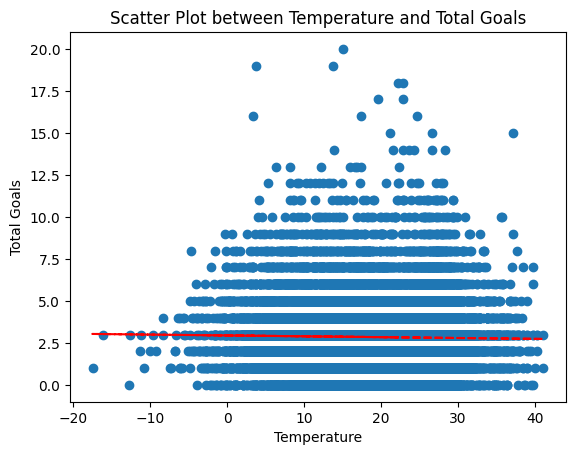

In [70]:
z = np.polyfit(df['temperature'], df['total_goals'], 1)
p = np.poly1d(z)
plt.plot(df['temperature'], p(df['temperature']), "r--")
plt.scatter(df['temperature'], df['total_goals'])
plt.xlabel('Temperature')
plt.ylabel('Total Goals')
plt.title('Scatter Plot between Temperature and Total Goals')
plt.show()

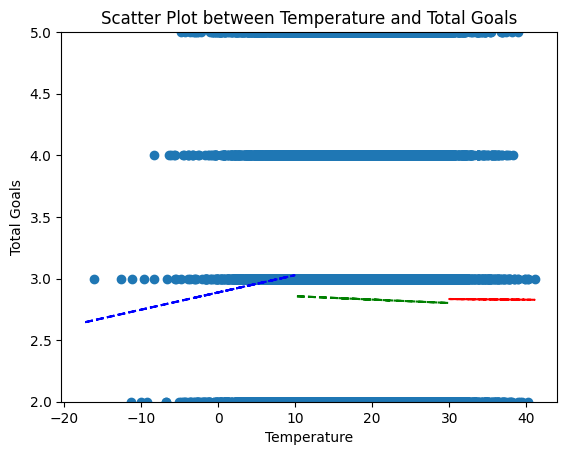

In [71]:

# Fit a linear trend line
z1 = np.polyfit(df[df['temperature'] < 10]['temperature'], df[df['temperature'] < 10]['total_goals'], 1)
p1 = np.poly1d(z1)
plt.plot(df[df['temperature'] < 10]['temperature'], p1(df[df['temperature'] < 10]['temperature']), "b--")

z2 = np.polyfit(df[(df['temperature'] >= 10) & (df['temperature'] < 30)]['temperature'], df[(df['temperature'] >= 10) & (df['temperature'] < 30)]['total_goals'], 1)
p2 = np.poly1d(z2)
plt.plot(df[(df['temperature'] >= 10) & (df['temperature'] < 30)]['temperature'], p2(df[(df['temperature'] >= 10) & (df['temperature'] < 30)]['temperature']), "g--")

z3 = np.polyfit(df[df['temperature'] >= 30]['temperature'], df[df['temperature'] >= 30]['total_goals'], 1)
p3 = np.poly1d(z3)
plt.plot(df[df['temperature'] >= 30]['temperature'], p3(df[df['temperature'] >= 30]['temperature']), "r--")

plt.scatter(df['temperature'], df['total_goals'])
plt.xlabel('Temperature')
plt.ylabel('Total Goals')
plt.ylim(2, 5)
plt.title('Scatter Plot between Temperature and Total Goals')
plt.show()

## Research questions:

### Question 1 - does temperature impact on the amount of goals scored per game

In [72]:
linear_model = smf.ols('total_goals ~ temperature_category_v2', data=df).fit()
# Save the summary of the linear model to a CSV file
with open('C:/Users/Mark Rozenberg/Foobal-Climate/Data/models-results/linear_model_summary_v1.csv', 'w') as f:
    f.write(linear_model.summary().as_csv())

In [73]:
linear_model = smf.ols('total_goals ~ temperature_category_v2 + precipitation', data=df).fit()
# Save the summary of the linear model to a CSV file
with open('C:/Users/Mark Rozenberg/Foobal-Climate/Data/models-results/linear_model_summary_v2.csv', 'w') as f:
    f.write(linear_model.summary().as_csv())

In [74]:
linear_model = smf.ols('total_goals ~ temperature_category_v2 + precipitation + snow', data=df).fit()
# Save the summary of the linear model to a CSV file
with open('C:/Users/Mark Rozenberg/Foobal-Climate/Data/models-results/linear_model_summary_v3.csv', 'w') as f:
    f.write(linear_model.summary().as_csv())

In [75]:
linear_model = smf.ols('total_goals ~ temperature_category_v2 + precipitation + snow + neutral', data=df).fit()
# Save the summary of the linear model to a CSV file
with open('C:/Users/Mark Rozenberg/Foobal-Climate/Data/models-results/linear_model_summary_v4.csv', 'w') as f:
    f.write(linear_model.summary().as_csv())

In [76]:
linear_model = smf.ols('total_goals ~ temperature_category_v2 + precipitation + snow + neutral + tournament', data=df).fit()
# Save the summary of the linear model to a CSV file
with open('C:/Users/Mark Rozenberg/Foobal-Climate/Data/models-results/linear_model_summary_v5.csv', 'w') as f:
    f.write(linear_model.summary().as_csv())

In [77]:
linear_model = smf.ols('total_goals ~ temperature_category_v2 + precipitation + snow + neutral + home_team', data=df).fit()
# Save the summary of the linear model to a CSV file
with open('C:/Users/Mark Rozenberg/Foobal-Climate/Data/models-results/linear_model_summary_v6.csv', 'w') as f:
    f.write(linear_model.summary().as_csv())

In [78]:
linear_model = smf.ols('total_goals ~ temperature_category_v2 + precipitation + snow + neutral + away_team', data=df).fit()
# Save the summary of the linear model to a CSV file
with open('C:/Users/Mark Rozenberg/Foobal-Climate/Data/models-results/linear_model_summary_v7.csv', 'w') as f:
    f.write(linear_model.summary().as_csv())

### random forest model

Feature Importances: {'temperature': 0.5265309793068765, 'precipitation': 0.4286619372654038, 'snow': 0.0003973255918100351, 'neutral': 0.0444097578359097}
Mean Squared Error: 4.2706472436039915
R^2 Score: -0.09394666043357836


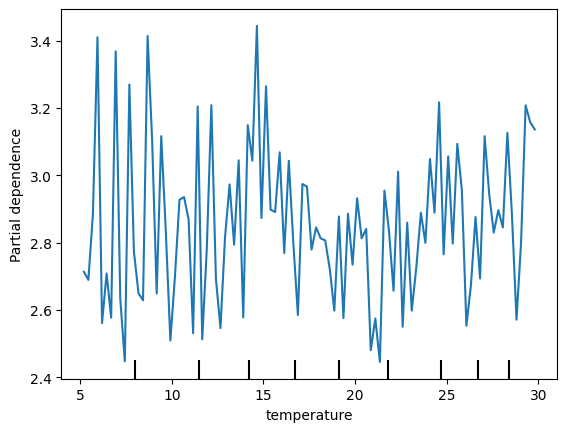

In [69]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

# Prepare the data
X = df[['temperature', 'precipitation', 'snow', 'neutral']]
y = df['total_goals']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model
rf_model.fit(X_train, y_train)

# Feature Importance
importances = rf_model.feature_importances_
print("Feature Importances:", dict(zip(X.columns, importances)))

# Partial Dependence Plot
PartialDependenceDisplay.from_estimator(rf_model, X_train, ['temperature'])

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

### Question 2 - if a team plays away game with climate that differs significanlty from home, does it impacts on win rate

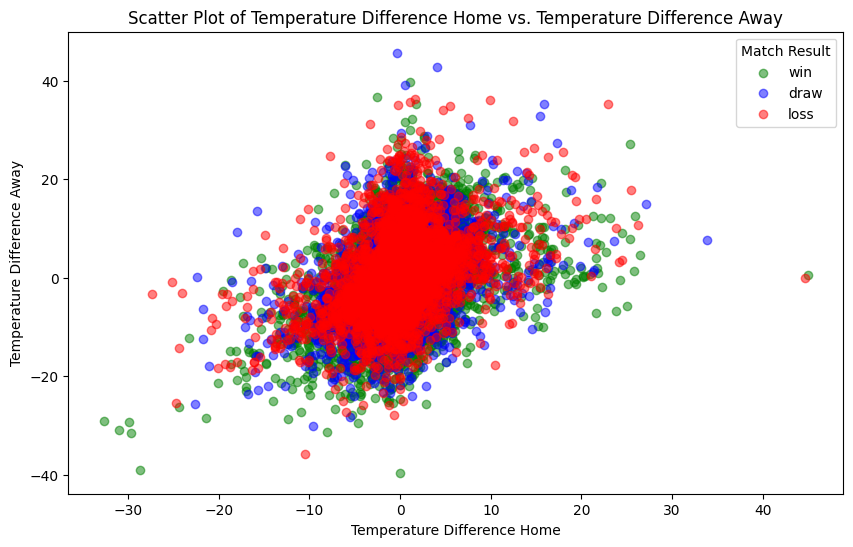

In [87]:
# Create a new column for match result
df['match_result'] = df.apply(lambda row: 'win' if row['home_score'] > row['away_score'] else ('draw' if row['home_score'] == row['away_score'] else 'loss'), axis=1)

# Create a scatter plot
colors = {'win': 'green', 'draw': 'blue', 'loss': 'red'}
plt.figure(figsize=(10, 6))
for result in colors:
    subset = df[df['match_result'] == result]
    plt.scatter(subset['tmp_diff_home'], subset['tmp_diff_away'], c=colors[result], label=result, alpha=0.5)

plt.xlabel('Temperature Difference Home')
plt.ylabel('Temperature Difference Away')
plt.title('Scatter Plot of Temperature Difference Home vs. Temperature Difference Away')
plt.legend(title='Match Result')
plt.show()

### Logistic regression

In [172]:
df.columns

Index(['date', 'home_team', 'away_team', 'home_score', 'away_score',
       'tournament', 'city', 'country', 'neutral', 'temperature',
       'precipitation', 'snow', 'total_goals', 'temperature_category',
       'temperature_category_v2', 'month', 'home_team_home_avg_tmp',
       'away_team_home_avg_tmp', 'tmp_diff', 'year', 'tmp_diff_home',
       'tmp_diff_away', 'home_win', 'home_avg_score', 'home_avg_points',
       'away_avg_score', 'away_avg_points'],
      dtype='object')

In [190]:
# Drop rows where any of the specified columns have null values
df_clear = df[['home_win', 'tmp_diff_home', 'tmp_diff_away', 'precipitation', 'snow', 'home_team', 'away_team', 'home_goals_ratio', 'away_goals_ratio', 'home_avg_points', 'away_avg_points']].dropna()
# df_clear = df.dropna(subset=['home_win', 'tmp_diff_home', 'tmp_diff_away', 'precipitation', 'snow'])
print('Original data shape: ', df.shape)
print('After clean data: ', df_clear.shape)

Original data shape:  (21310, 27)
After clean data:  (15291, 11)


### Version 1

In [191]:
import statsmodels.api as sm
# Define the independent variables and the dependent variable (home_win)
X = df_clear.drop(columns=['home_win', 'home_team', 'away_team', 'home_goals_ratio', 'away_goals_ratio', 'home_avg_points', 'away_avg_points'])
y = df_clear['home_win']

In [192]:
print('Independent vars: ', X.dtypes)
print('dependent var: ', y.dtypes)

Independent vars:  tmp_diff_home    float64
tmp_diff_away    float64
precipitation    float64
snow             float64
dtype: object
dependent var:  float64


In [193]:
import statsmodels.api as sm
import numpy as np

# Add a constant to the independent variables
X = sm.add_constant(X)

# Fit the logistic regression model
logit_model = sm.Logit(y, X).fit()

# Print the summary of the logistic regression model
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.691257
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:               home_win   No. Observations:                15291
Model:                          Logit   Df Residuals:                    15286
Method:                           MLE   Df Model:                            4
Date:                Thu, 09 Jan 2025   Pseudo R-squ.:                0.001890
Time:                        15:38:16   Log-Likelihood:                -10570.
converged:                       True   LL-Null:                       -10590.
Covariance Type:            nonrobust   LLR p-value:                 4.249e-08
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0654      0.017     -3.951      0.000      -0.098      -0.033
tmp_diff_home     0.

### Version 2

In [194]:
import statsmodels.api as sm
# Define the independent variables and the dependent variable (home_win)
X = df_clear.drop(columns=['home_win', 'home_team', 'away_team'])
y = df_clear['home_win']

In [196]:
print('Independent vars: ', X.dtypes)
print('dependent var: ', y.dtypes)

Independent vars:  tmp_diff_home       float64
tmp_diff_away       float64
precipitation       float64
snow                float64
home_goals_ratio    float64
away_goals_ratio    float64
home_avg_points     float64
away_avg_points     float64
dtype: object
dependent var:  float64


### we will drop matches that occured only once. this should help with singular matrix in logit model

In [197]:
import statsmodels.api as sm
import numpy as np

# Add a constant to the independent variables
X = sm.add_constant(X)

# Fit the logistic regression model
logit_model = sm.Logit(y, X).fit()

# Print the summary of the logistic regression model
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.516720
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               home_win   No. Observations:                15291
Model:                          Logit   Df Residuals:                    15282
Method:                           MLE   Df Model:                            8
Date:                Thu, 09 Jan 2025   Pseudo R-squ.:                  0.2539
Time:                        15:38:46   Log-Likelihood:                -7901.2
converged:                       True   LL-Null:                       -10590.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.8356      0.085     -9.882      0.000      -1.001      -0.670
tmp_diff_ho

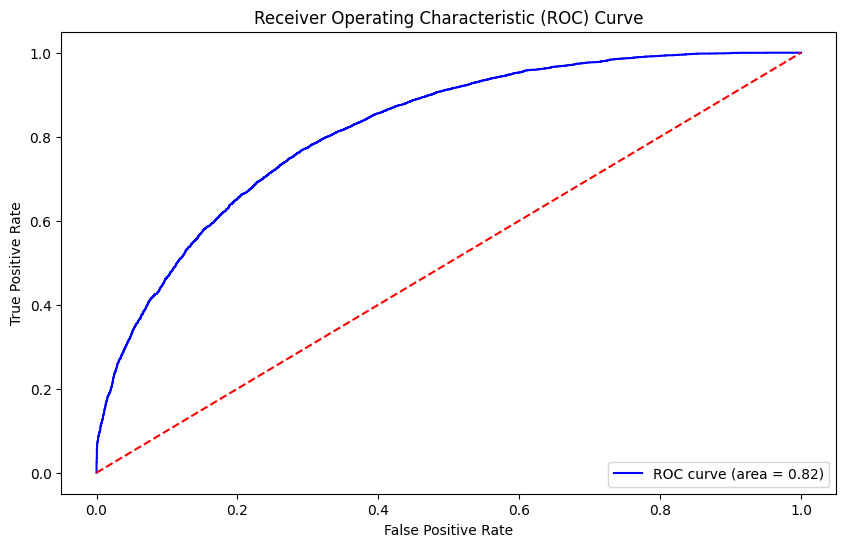

In [198]:
from sklearn.metrics import roc_curve, roc_auc_score

import matplotlib.pyplot as plt

# Predict probabilities
y_pred_prob = logit_model.predict(X)

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y, y_pred_prob)

# Compute AUC
roc_auc = roc_auc_score(y, y_pred_prob)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [199]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the Random Forest model
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.74      0.74      0.74      1589
         1.0       0.72      0.71      0.71      1470

    accuracy                           0.73      3059
   macro avg       0.73      0.73      0.73      3059
weighted avg       0.73      0.73      0.73      3059



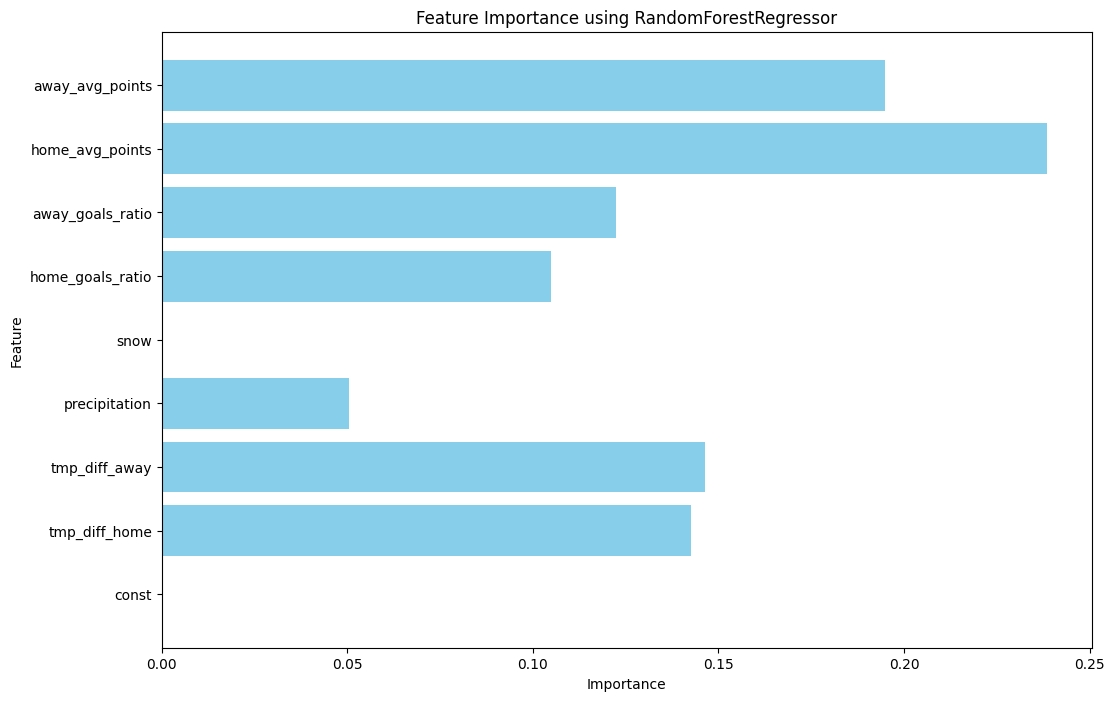

In [200]:
# Fit the Random Forest Regressor model
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)

# Get feature importances
importances = rf_regressor.feature_importances_

# Create a DataFrame for the feature importances
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})

# Plot the feature importances
plt.figure(figsize=(12, 8))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance using RandomForestRegressor')
plt.show()